# Data augmentation

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, roc_curve
import numpy as np
from keras.callbacks import Callback
from IPython.display import clear_output

## Loading best result grid search

In [2]:
df = pd.read_csv("/kaggle/input/image-size-gridsearch-result/image_size_gridsearch_result(1).csv")
df.drop(columns=["Unnamed: 0"], inplace=True)
df = df.sort_values("test_accuracy", ascending=False)
df.head()

,statistic,interpolation,width,height,train_accuracy,val_accuracy,test_accuracy,train_loss,val_loss,precision,recall,f1_score,auc
17,median,area,550,590,0.964126,0.895442,0.797844,0.134882,1.276011,0.832370,0.944262,0.884793,0.534799
16,median,bicubic,550,590,0.966816,0.908847,0.776280,0.132820,0.531361,0.832335,0.911475,0.870110,0.487556
29,75%,nearest,800,826,0.981166,0.924933,0.727763,0.079351,0.589723,0.818750,0.859016,0.838400,0.519598
15,median,nearest,550,590,0.965919,0.895442,0.725067,0.362679,0.558886,0.834983,0.829508,0.832237,0.549031
18,median,lanczos3,550,590,0.965919,0.898123,0.722372,0.324835,0.533067,0.827922,0.836066,0.831974,0.531396


Class_weight is overgenomen uit notebook 4

In [3]:
best_result = df.iloc[0]
width = best_result["width"]
height = best_result["height"]
statistic = best_result["statistic"]
interpolation = best_result["interpolation"]
painters = ["Mondriaan", "Picasso"]
base_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset/imbalanced_dataset"
class_weight = {0: 2.8156565656565657, 1: 0.6079607415485279}

## Helper functions

In [4]:
def build_model(width, height, data_augmentation=None):
    model = keras.Sequential()
    model.add(layers.InputLayer(shape=(width, height, 3)))

    if data_augmentation:
        model.add(data_augmentation)

    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(32, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(256, 3, activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    return model

model = build_model(width, height)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 550, 590, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 548, 588, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 274, 294, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 272, 292, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 136, 146, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 134, 144, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 67, 72, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 65, 70, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 35, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 33, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 253440)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         253,441 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,231,937 (4.70 MB)

 Trainable params: 1,231,937 (4.70 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
def load_dataset(base_dir, painters, width, height, batch_size=16, interpolation="bilinear"):
    train_dataset = image_dataset_from_directory(
        f'{base_dir}/train',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    validation_dataset = image_dataset_from_directory(
        f'{base_dir}/validation',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    test_dataset = image_dataset_from_directory(
        f'{base_dir}/test',
        labels='inferred',
        label_mode='int',
        class_names=painters,
        image_size=(width, height),
        batch_size=batch_size,
        interpolation=interpolation
    )
    return train_dataset, validation_dataset, test_dataset

In [6]:
def print_metrics(model, test):
    y_pred_prob = model.predict(test)
    y_pred = np.where(y_pred_prob > 0.5, 1, 0)
    y_true = np.concatenate([y.numpy() for _, y in test], axis=0)

    auc_score = roc_auc_score(y_true, y_pred_prob)

    print("Accuracy: ", accuracy_score(y_true, y_pred))
    print("Recall: ", recall_score(y_true, y_pred))
    print("Precision: ", precision_score(y_true, y_pred))
    print("F1: ", f1_score(y_true, y_pred))
    print("ROC AUC: ", roc_auc_score(y_true, y_pred))

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ConfusionMatrixDisplay.from_predictions(
        y_true, 
        y_pred, 
        display_labels=['Class 0', 'Class 1'], 
        ax=ax[0]
    )
    ax[0].set_title('Confusion Matrix')
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    ax[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
    ax[1].plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title('Receiver Operating Characteristic (ROC)')
    ax[1].legend(loc='lower right')
    ax[1].grid()

In [7]:
def display_augmentation():
    for images, _ in train.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")

In [8]:
class DynamicMetricsPlotCallback(Callback):
    def __init__(self):
        super().__init__()
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
       
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for metric in self.history.keys():
            if metric in logs:
                self.history[metric].append(logs[metric])
       
        clear_output(wait=True)
        plt.figure(figsize=(12, 4))
       
        # Loss plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history['loss'], label='Training Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
       
        # Accuracy plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
       
        plt.tight_layout()
        plt.show()

## Data augmentation

### Base model

In [9]:
painters = ["Mondriaan", "Picasso"]
# dataset_dir = "imbalanced_dataset"
dataset_dir = "/kaggle/input/schilderijen-datasets/imbalanced_dataset"
train, val, test = load_dataset(dataset_dir, painters, width, height, interpolation=interpolation)

Found 1115 files belonging to 2 classes.
Found 373 files belonging to 2 classes.
Found 371 files belonging to 2 classes.


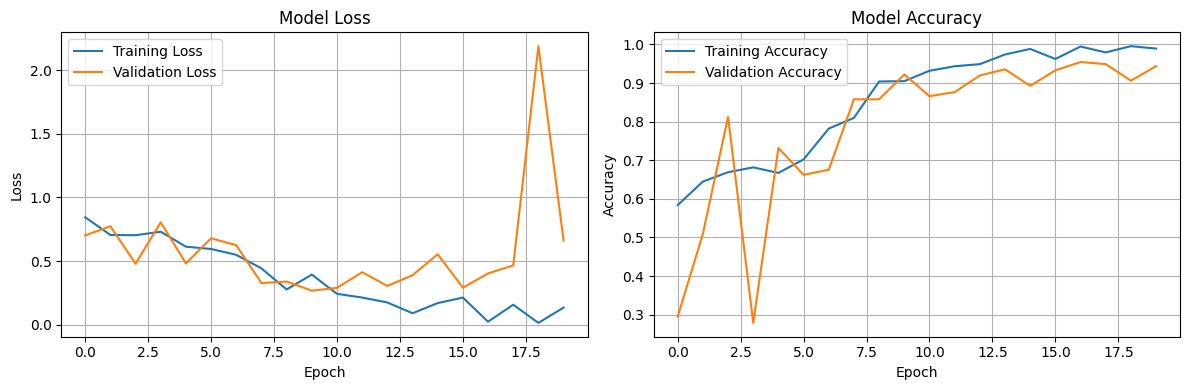

In [103]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="base_model.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(width, height)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=20, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
Accuracy:  0.6819407008086253
Recall:  0.8065573770491803
Precision:  0.8065573770491803
F1:  0.8065573770491803
ROC AUC:  0.45630899155489324


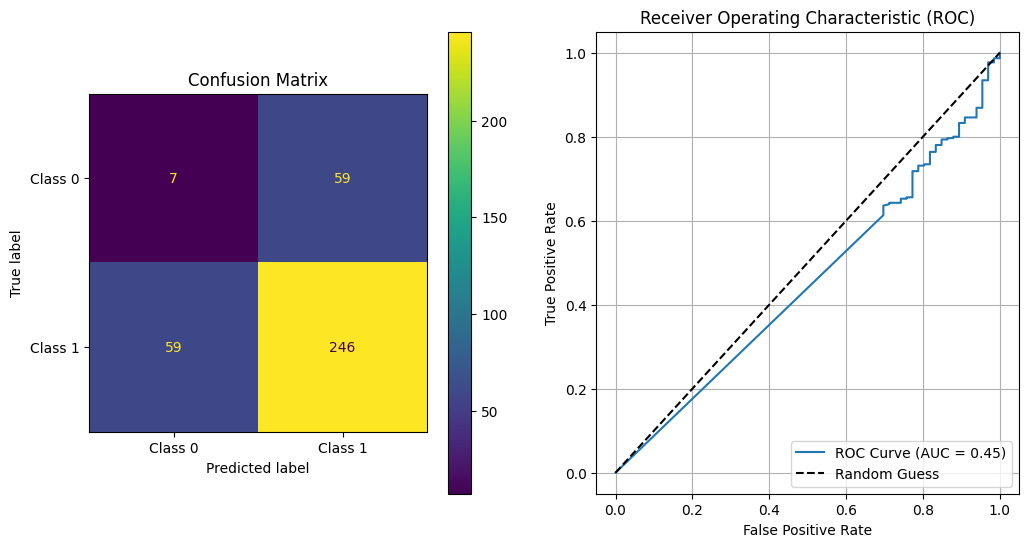

In [104]:
print_metrics(model, test)

### Randomflip

In [105]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
])

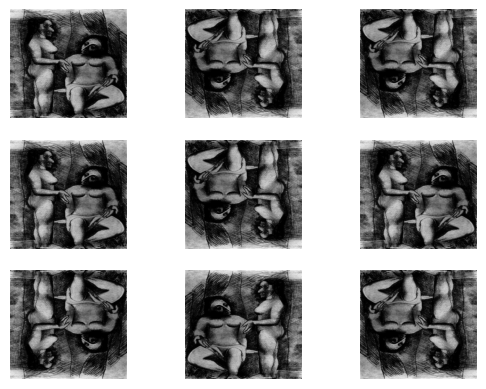

In [106]:
display_augmentation()

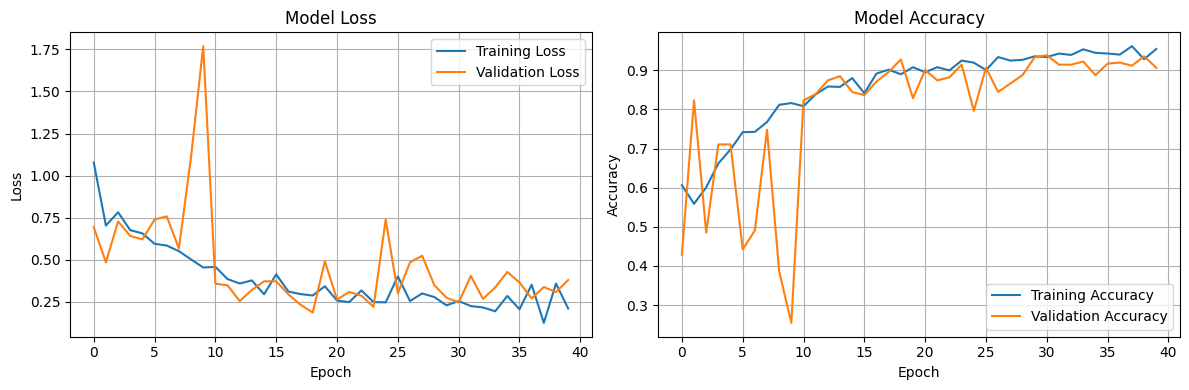

In [107]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=40, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Accuracy:  0.6873315363881402
Recall:  0.7770491803278688
Precision:  0.8315789473684211
F1:  0.8033898305084746
ROC AUC:  0.5248882265275708


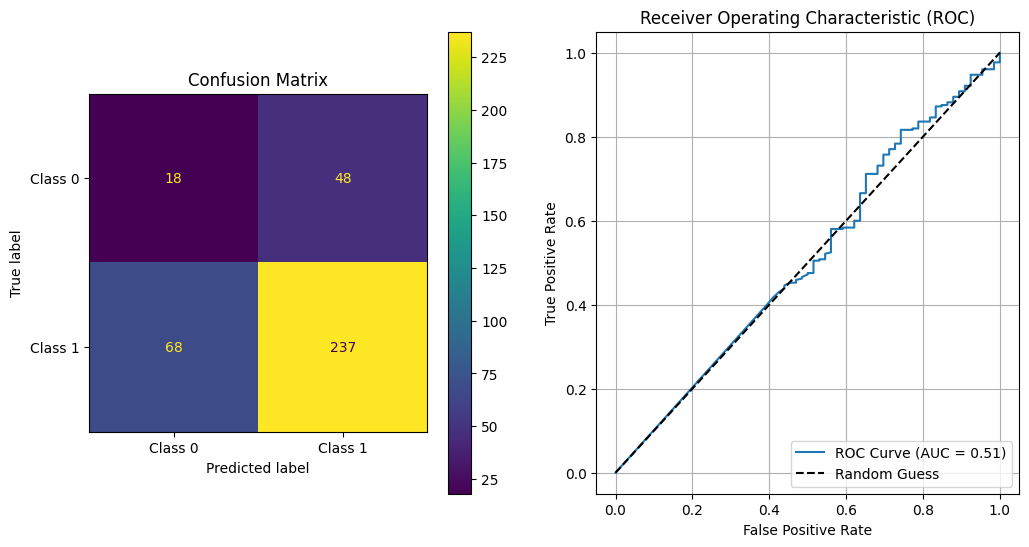

In [108]:
print_metrics(model, test)

### RandomTranslation

In [109]:
data_augmentation = keras.Sequential([
    layers.RandomTranslation(0.3, 0.3),
])

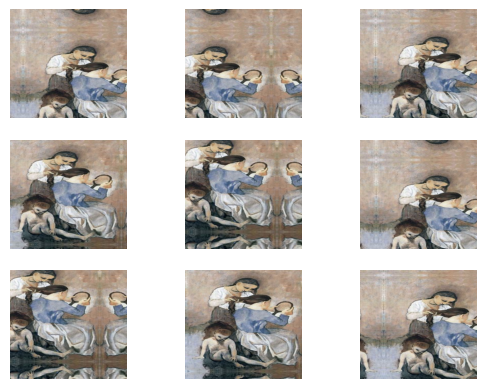

In [110]:
display_augmentation()

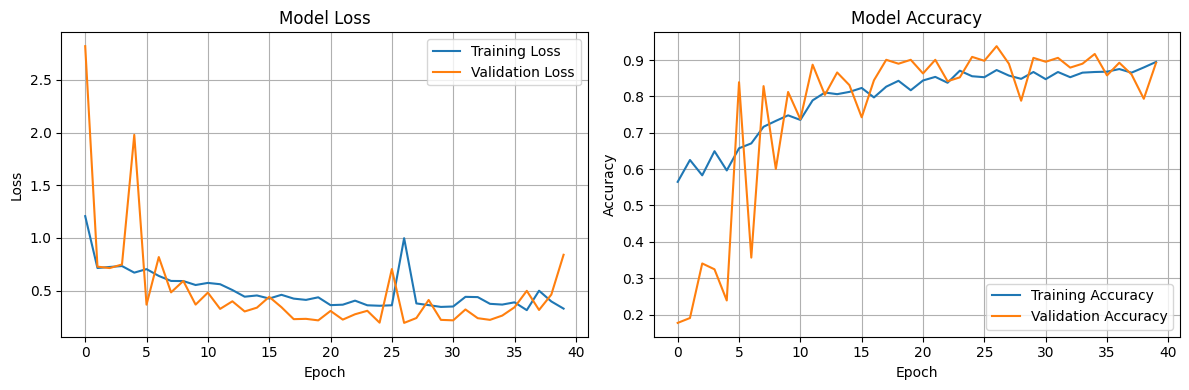

In [111]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=40, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Accuracy:  0.7547169811320755
Recall:  0.8819672131147541
Precision:  0.8302469135802469
F1:  0.8553259141494436
ROC AUC:  0.5243169398907104


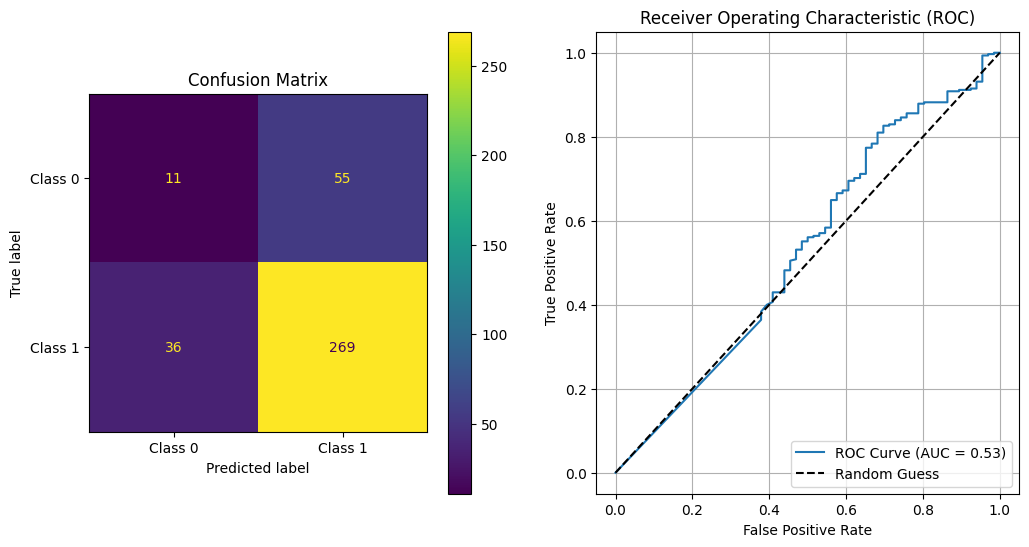

In [112]:
print_metrics(model, test)

### RandomZoom

In [113]:
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.3),
])

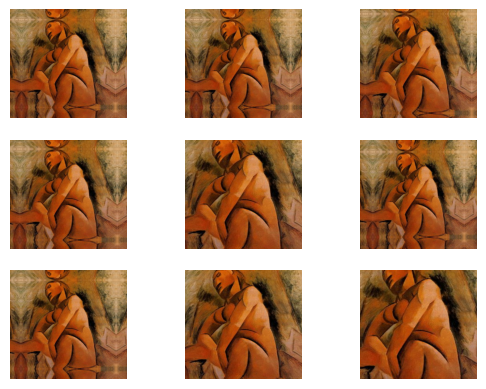

In [114]:
display_augmentation()

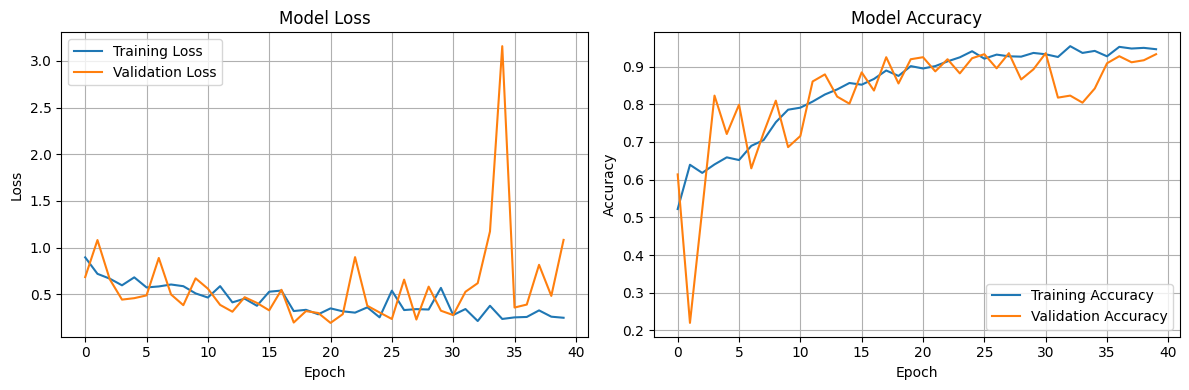

In [115]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=40, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Accuracy:  0.7331536388140162
Recall:  0.839344262295082
Precision:  0.8366013071895425
F1:  0.8379705400981997
ROC AUC:  0.5408842523596622


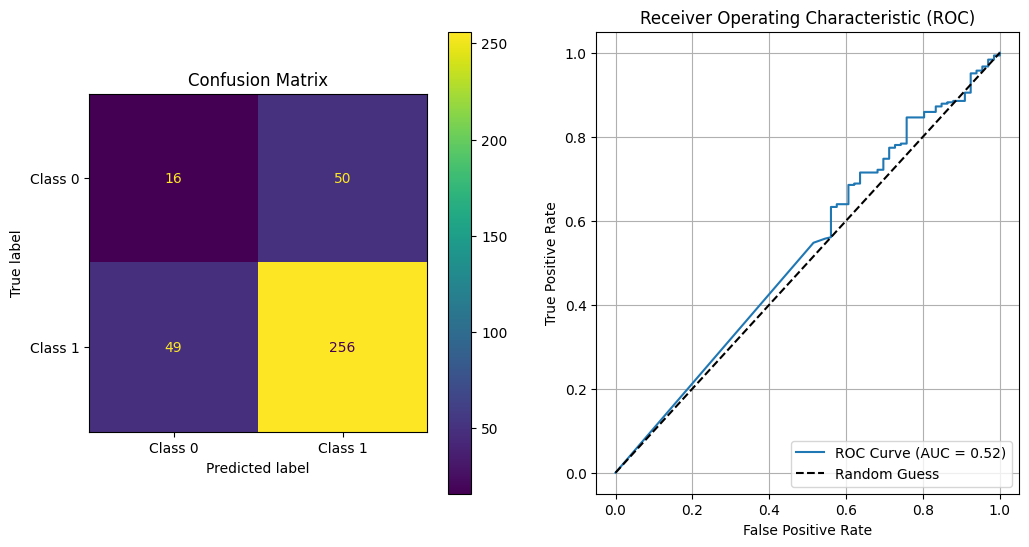

In [116]:
print_metrics(model, test)

### RandomContrast

In [117]:
data_augmentation = keras.Sequential([
    layers.RandomContrast(0.3),
])

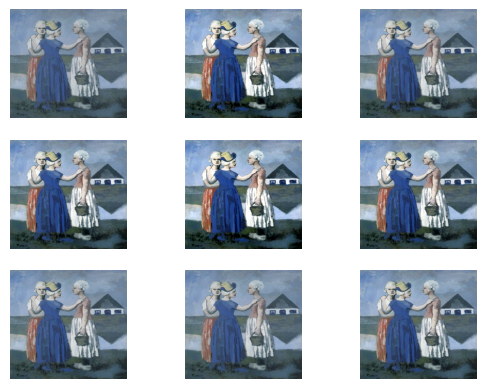

In [118]:
display_augmentation()

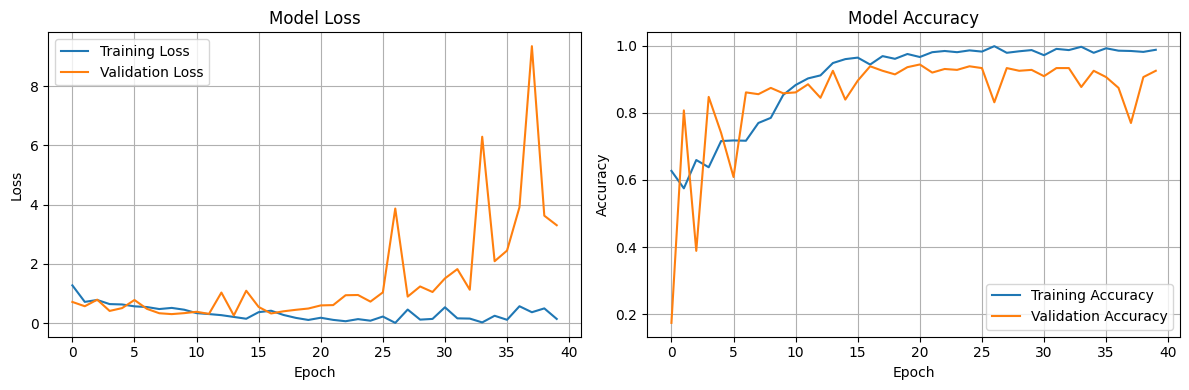

In [119]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=40, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step
Accuracy:  0.6900269541778976
Recall:  0.7836065573770492
Precision:  0.8298611111111112
F1:  0.806070826306914
ROC AUC:  0.5205911574764034


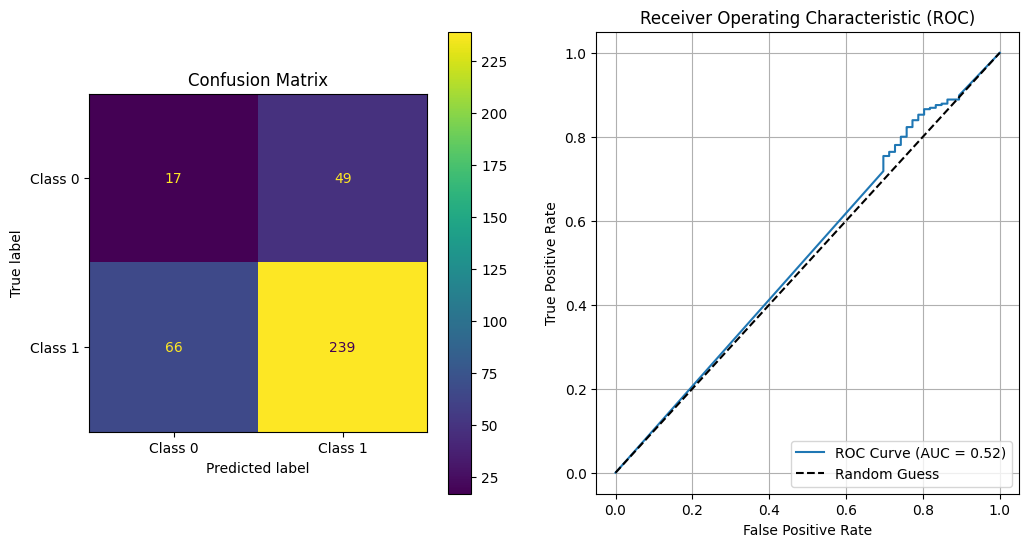

In [120]:
print_metrics(model, test)

### Using best 2 data augmentations

In [13]:
data_augmentation = keras.Sequential([
    layers.RandomZoom(0.3),
    layers.RandomTranslation(0.3, 0.3)
])

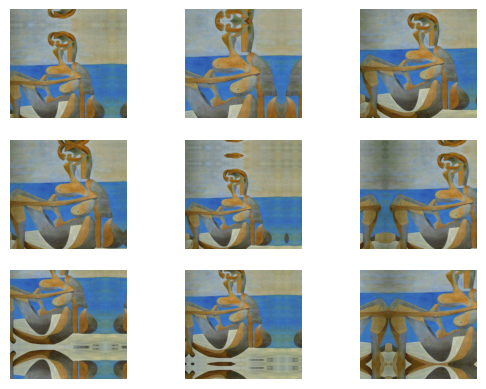

In [14]:
display_augmentation()

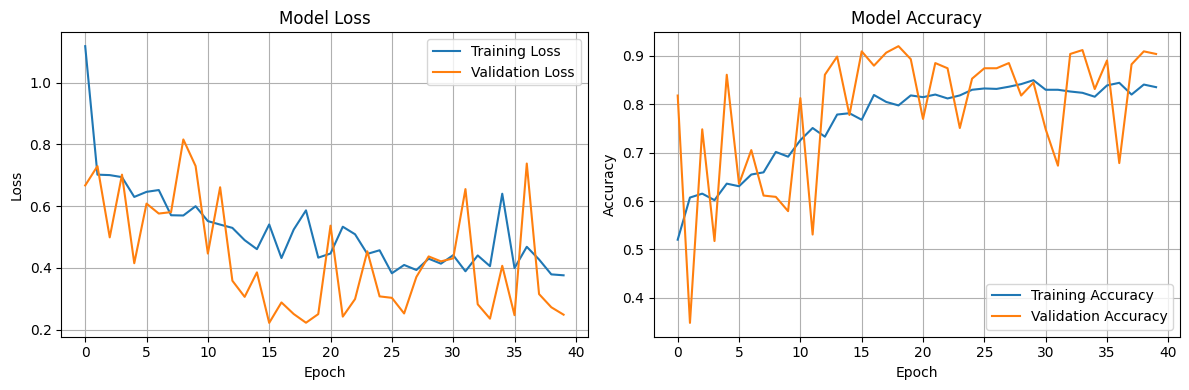

In [15]:
callbacks = [keras.callbacks.ModelCheckpoint(filepath="data_augmentation.keras", save_best_only=True, monitor="val_loss"), DynamicMetricsPlotCallback()]
model = build_model(width, height, data_augmentation)
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(train, epochs=40, validation_data=val, callbacks=callbacks, class_weight=class_weight, verbose=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step
Accuracy:  0.6765498652291105
Recall:  0.7737704918032787
Precision:  0.8222996515679443
F1:  0.7972972972972974
ROC AUC:  0.500521609538003


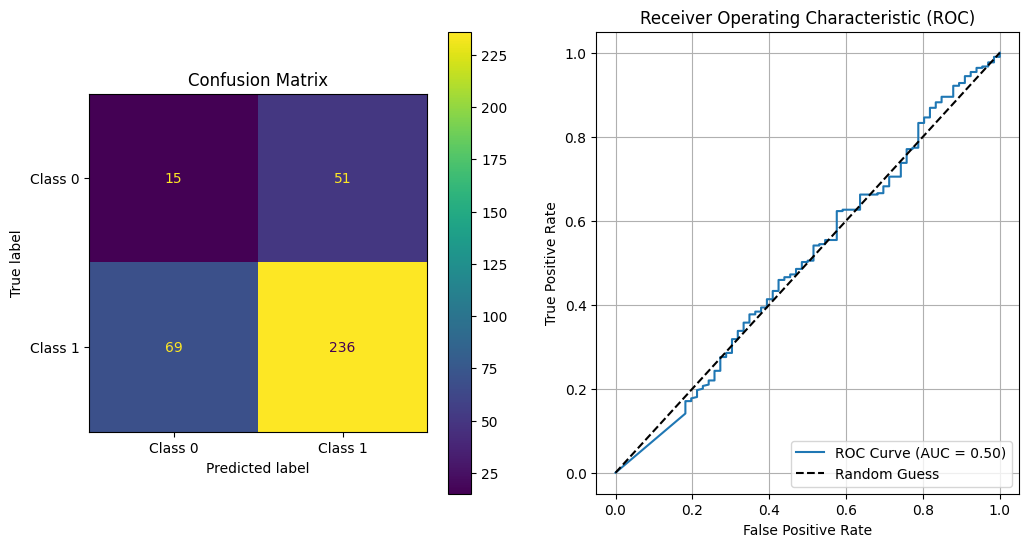

In [16]:
print_metrics(model, test)